In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

import itertools

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, RandomizedSearchCV, cross_validate, RepeatedKFold

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from scipy.stats import loguniform

import warnings

warnings.filterwarnings('ignore')

## Dataset and Task Overview
The dataset I chose from Kaggle contains information about online consumer purchasing habits, as well as some demographic data related to the buyers. The aim of this project is to perform a binary classification task, leveraging the users' 'profiles' to predict whether they will or will not click on an advertisement.

Let's take a closer look to the features in the dataset:

- **`Daily Time Spent on Site`**: the average daily time the consumer spends on the website, expressed in minutes;

- **`Age`**: the consumer's age;
- **`Area Income`**: the average income of the consumer's geographical area;
- **`Daily Internet Usage`**: the average daily time the consumer spends on the internet, expressed in minutes;
- **`Ad Topic Line`**: the headline of the advertisement;
- **`City`**: the city of the consumer;
- **`Male`**: the consumer's gender. This is a binary feature assigning 1 to male consumers and 0 to females;
- **`Country`**: the country of the consumer;
- **`Timestamp`**: the exact time at which the consumer clicked on the advertisement or closed the window. The format is YYYY-MM-DD HH:MM:SS;
- **`Clicked on Ad`**: whether the consumer clicked on the advertisement or not. This is our target variable: 1 indicates engaging, while 0 implies not clicking on the ad.

First of all, let's import the dataset using pandas.

In [48]:
df = pd.read_csv('advertising.csv')

In [60]:
df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0


In [67]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


## Explorative Data Analysis
Now, we will try to gain as much information as possible from our dataset, through EDA. 

First and foremost, we want to understand the structure of our data, computing summary statistics and understanding which types of data we are dealing with. 

Then, we want to identify potential missing values, which we will eventually handle during preprocessing. 

Finally, we would like to display underlying patterns and correlations among features with the help of various plotting strategies, which can be crucial in identifying the most important features and removing redundant or irrelevant ones.

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


We can use `df.describe()` to generate descriptive statistics for the DataFrame's numeric columns. In particular, the method shows how many non-null values are present and provides a quick overview of the central tendency, dispersion and shape of the dataset's distribution.

In [77]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


We can see that the mean is pretty close to the median (second quartile), so we expect the data to be rather simmetrically distributed.

Also, even though `Clicked on Ad` is a binary feature, the mean value for the target column is still very informative, telling us that half of the users clicked on the ad. This suggests the classes to perdict are balanced.

We can additionally check this through the `value_counts()` method.

In [79]:
df['Clicked on Ad'].value_counts()

Clicked on Ad
0    500
1    500
Name: count, dtype: int64

As we expected, they are perfectly balanced. This implies we won't need to implement oversampling or undersampling techniques later in the model.

Let's now check for missing values.

In [80]:
df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

<AxesSubplot: >

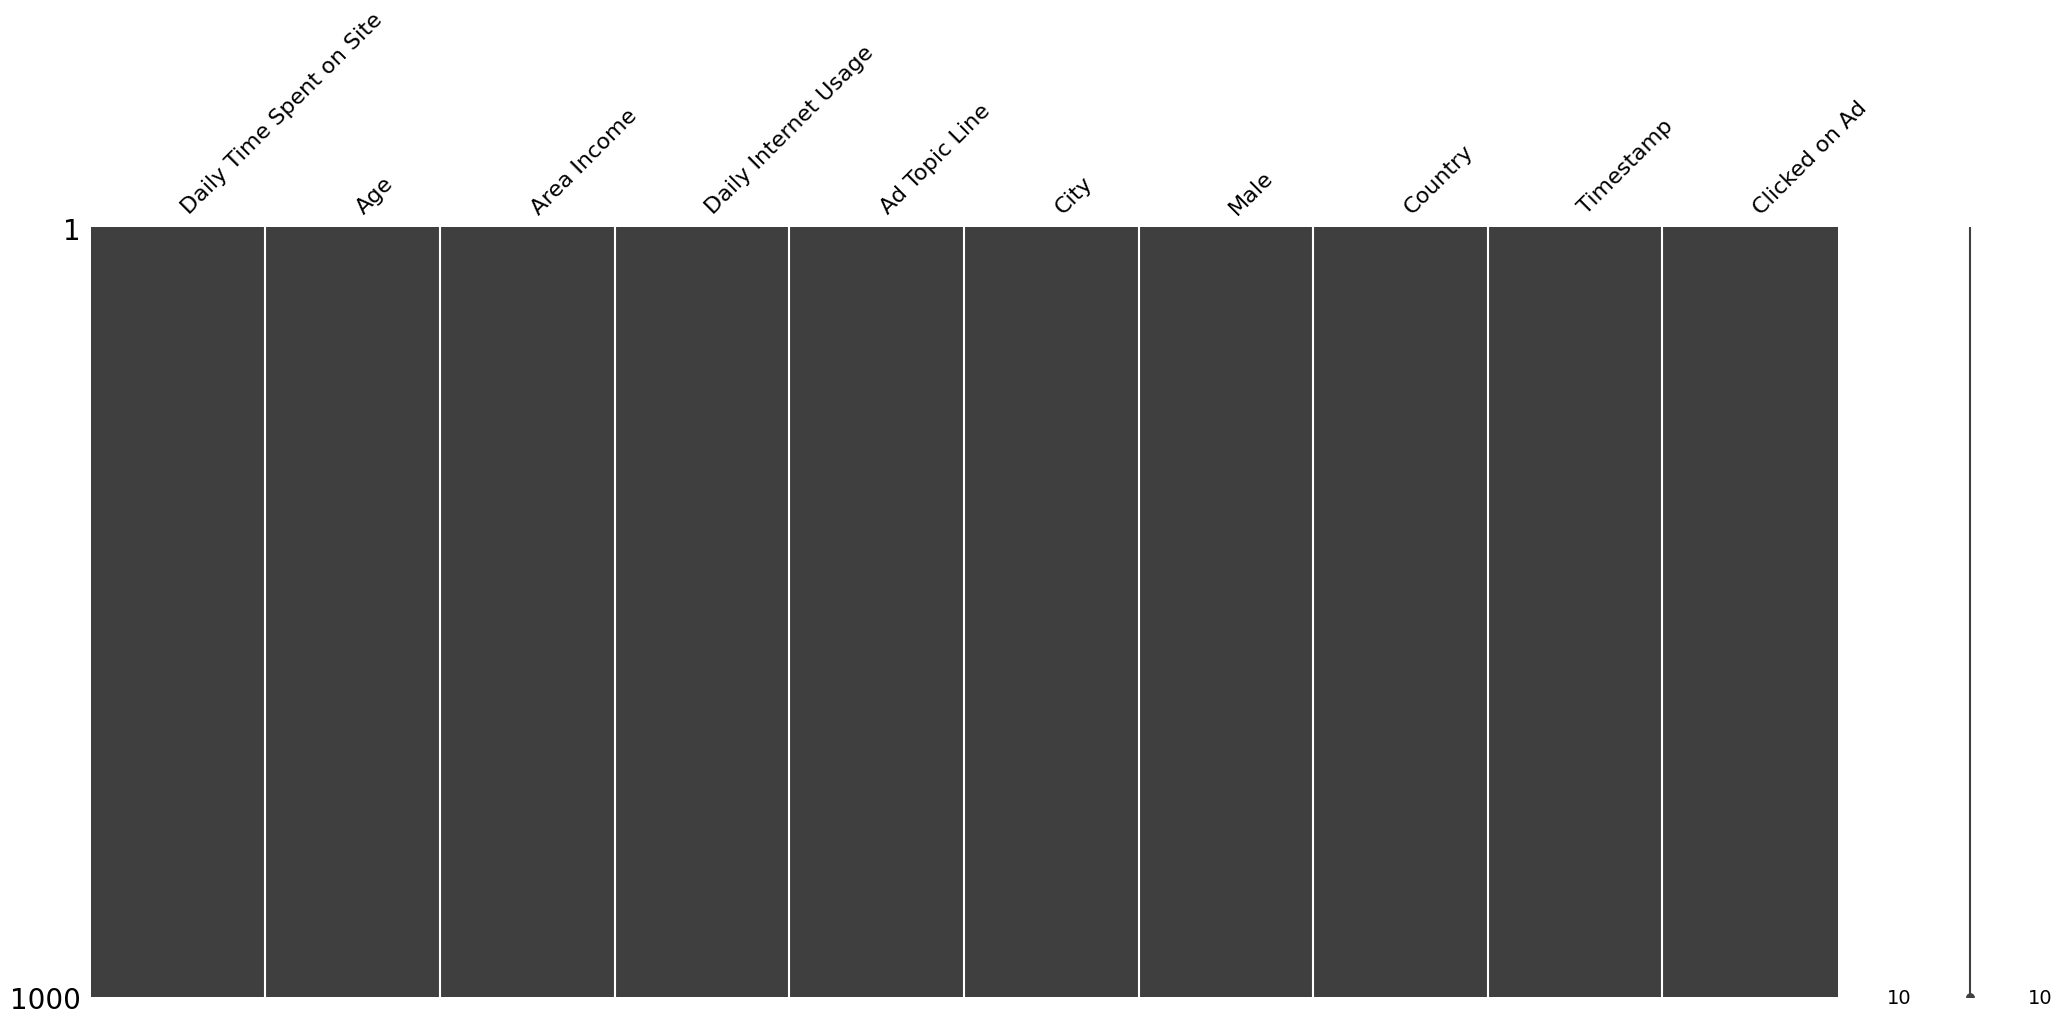

In [81]:
msno.matrix(df)

The dataset appears to be already clean. To help prevent overfitting, enhance robustness and increase generalization capabilities, we will later add some noise.

For now, let's see what graphs can tell us about the relationships between data.

#### Heatmap

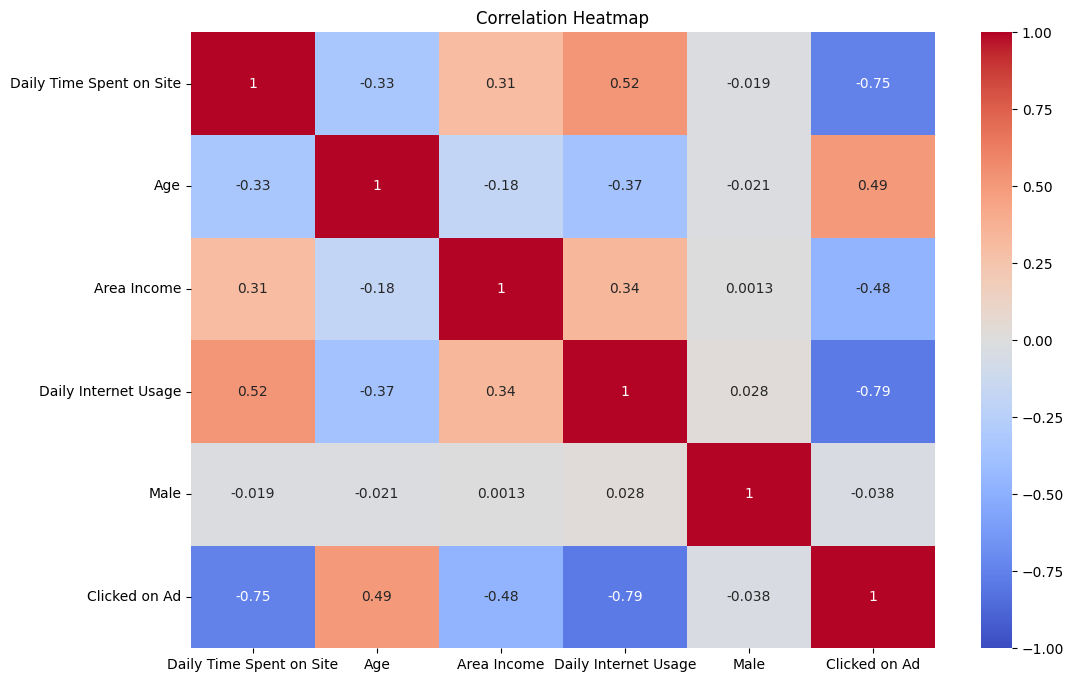

In [82]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap offers fairly noteworthy relations between data. 

We see, for instance, that `Daily Time Spent on Site` and `Daily Internet Usage` have very strong negative correlations with our target variable, suggesting that customers who spend more time on the website, or generally online, are less likely to click on ads. 

On the other hand, the increase in `Age` appears to impact significantly on ad engagement, with younger consumers seemingly less involved than older ones. 

`Area Income` also plays an important role, indicating an inverse relationship between a user's financial means and their likelihood of clicking on an advertisement, while gender doesn't seem to be a crucial factor at all, as `Male` doesn't have particular correlations with any other variables.

#### Distplot

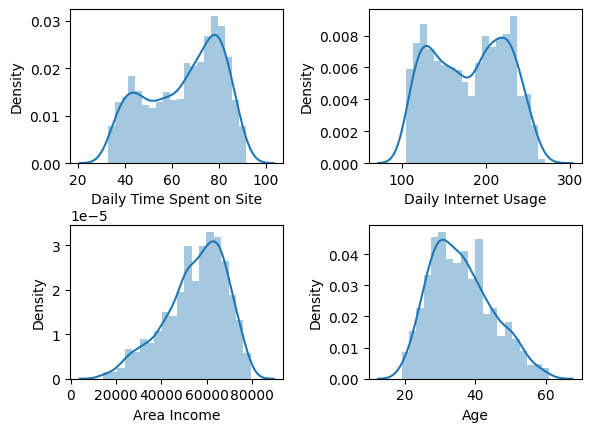

In [84]:
numerical_cols = ['Daily Time Spent on Site','Daily Internet Usage','Area Income','Age']

def distPlot(df):
    for i,col in enumerate(numerical_cols,start=1):
        plt.subplot(2,2,i)
        sns.distplot(df[col],bins=20)   
    plt.subplots_adjust(left = 0.1,right=0.9,wspace=0.4,hspace=0.4)

distPlot(df)

Distplots, used for univariate analysis, are useful to understand the distribution of a dataset, providing both the frequency of observations in different bins and a smoothed version of the histogram, called KDE (Kernel Density Estimate), which estimates the probability density function of the data. 

Here, we again delved into numerical columns analysis, discovering that while `Area Income` and `Age` tend to follow a normal distribution, with a slight right and left skewness respectively, `Daily Time Spent on Site` and `Daily Internet Usage` display the presence of bimodal distributions. The presence of two peaks may be indicate that clustering algorithms like K-means migth be useful to identify and separate underlying groups within the data.

#### Pair Plot

We can summarize the structure of our data though a pair plot, which shows scatterplots of all pairs of variables, plus the univariate distribution of each variable on the diagonal.

Text(0.5, 1.02, 'Pair Plot of Features by Ad Click')

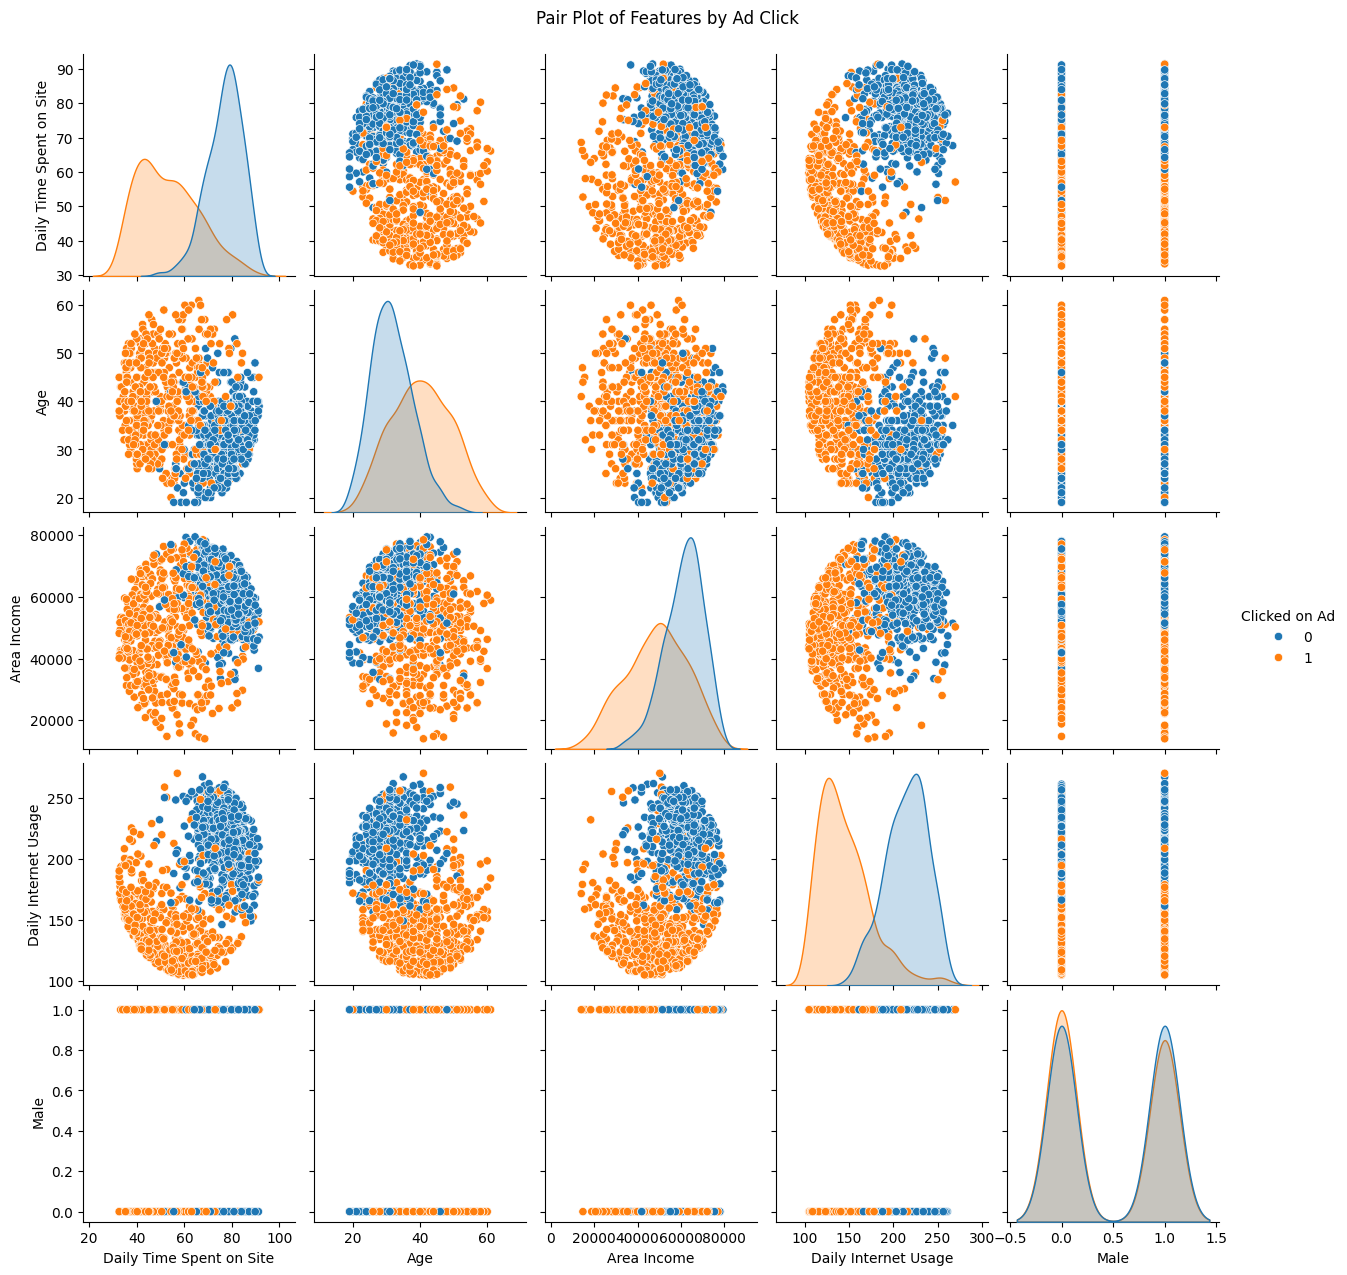

In [85]:
# Plotting pair plot
sns.pairplot(df, hue='Clicked on Ad')
plt.suptitle('Pair Plot of Features by Ad Click', y=1.02)

#### Categorical Features

The first feature we are going to drop is `Ad Topic Line`, as we are aiming at enhancing model efficiency and relevance. While the column contains potentially valuable textual data, performing the necessary tokenization and vectorization would significantly increase dimensionality and computational overhead. Moreover, the dataset already comprises straightforward features that exhibit strong correlations with the target variable.

In [86]:
df.drop(['Ad Topic Line'], axis=1, inplace=True)

In [87]:
df['City'].value_counts()

City
Lisamouth         3
Williamsport      3
Wrightburgh       2
Lake Jose         2
Robertfurt        2
                 ..
Burgessside       1
Hurleyborough     1
Garychester       1
East Kevinbury    1
Ronniemouth       1
Name: count, Length: 969, dtype: int64

In [88]:
df['Country'].value_counts()

Country
France                                                 9
Czech Republic                                         9
Peru                                                   8
Turkey                                                 8
Greece                                                 8
                                                      ..
Romania                                                1
British Indian Ocean Territory (Chagos Archipelago)    1
Germany                                                1
Aruba                                                  1
Lesotho                                                1
Name: count, Length: 237, dtype: int64

From a brief analysis, we see that the other categorical features in our dataset have a very high cardinality. 

This applies especially to `City`, whose top category 'Lisamouth' only has a frequency of 3. Having 969 unique values out of 1000 entries evidently does not constitute a meaningful aid to our preediction task. 

In fact, it may rather raise issues later on, such as increasing dimensionality and model complexity, creating sparse matrices due to the need for one-hot encoding, all of which can lead to overfitting and poor generalization to new data. 

Since the frequencies are extremely low for all categories, I would not procede by grouping categories, nor by masking, as it would signify dropping a large portion of our data, losing too much information. 

I will then procede by dropping the feature `City`, but still keeping `Country`, in hopes it will not alter our predictions negatively.

In [89]:
df.drop(['City'], axis=1, inplace=True)

#### Time-related Features

`Timestamp` can potentially represent a very interesting feature. However, the compact format it uses is not very descriptive. I will thus make it readable by pandas and explore the time-related patterns and correlations to our target variable (ad-clicks by hour of the day, day of the minth and month of the year).

In [90]:
df['Timestamp'].value_counts()

Timestamp
2016-03-27 00:53:11    1
2016-01-07 23:02:43    1
2016-04-05 08:18:45    1
2016-04-17 18:38:14    1
2016-02-03 16:54:33    1
                      ..
2016-03-13 13:50:25    1
2016-07-16 14:13:54    1
2016-04-18 00:49:33    1
2016-07-17 01:13:56    1
2016-06-03 21:43:21    1
Name: count, Length: 1000, dtype: int64

In [91]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [92]:
# Adding new columns to our dataframe for month, day and hour patterns
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour

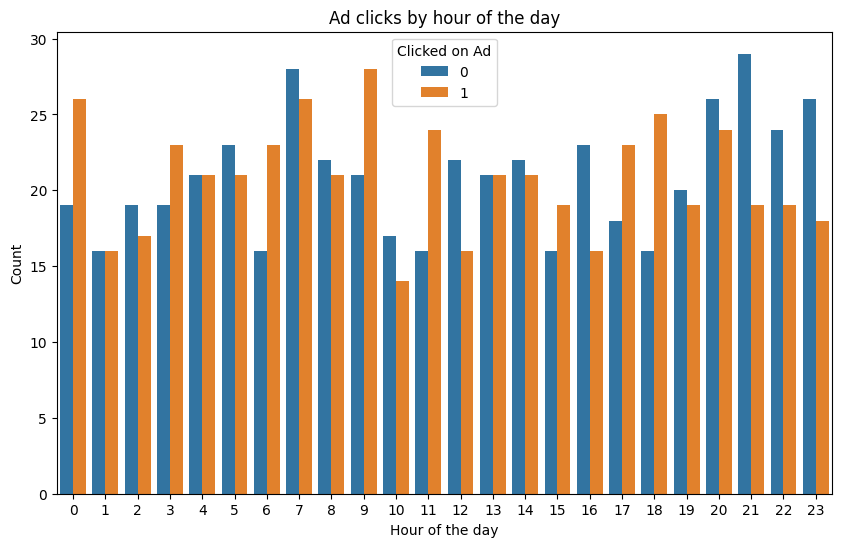

In [94]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Hour', hue='Clicked on Ad')
plt.title('Ad clicks by hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('Count')
plt.show()

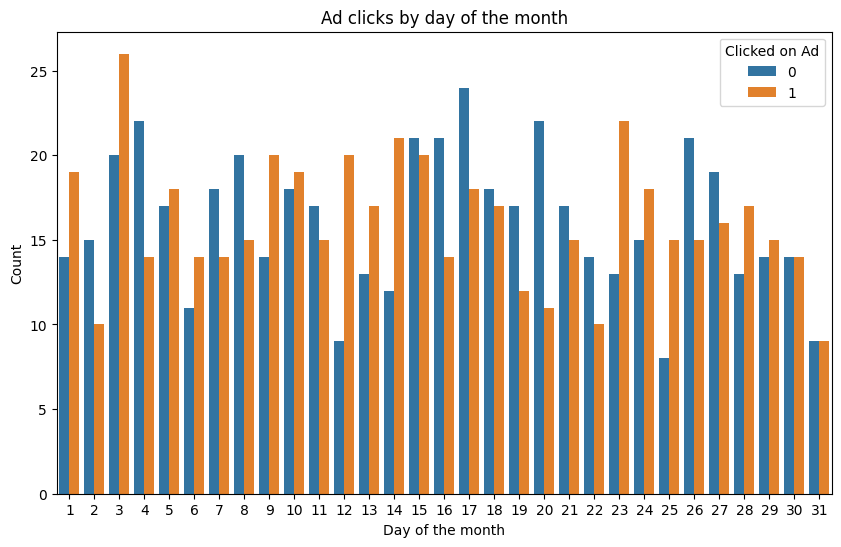

In [95]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Day', hue='Clicked on Ad')
plt.title('Ad clicks by day of the month')
plt.xlabel('Day of the month')
plt.ylabel('Count')
plt.show()

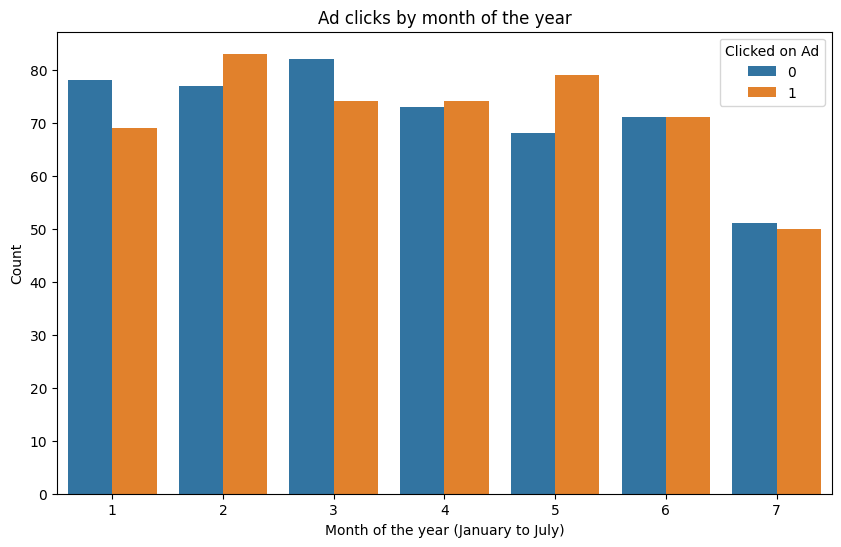

In [96]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Month', hue='Clicked on Ad')
plt.title('Ad clicks by month of the year')
plt.xlabel('Month of the year (January to July)')
plt.ylabel('Count')
plt.show()

We can summarize trends over time in a very straightforward manner with line plots.

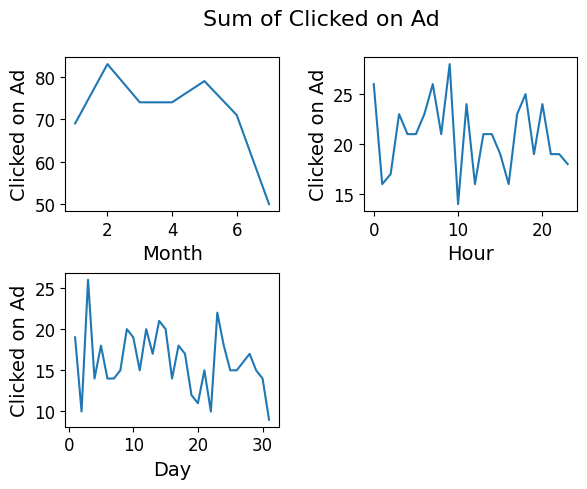

In [97]:
date_columns = ['Month','Hour','Day']

for i,col in enumerate(date_columns,start=1):
    plt.subplot(2,2,i)
    sns.lineplot(df.groupby(col)['Clicked on Ad'].sum())
    plt.xlabel(col,size = 14)
    plt.ylabel('Clicked on Ad',size = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)

plt.suptitle('Sum of Clicked on Ad',size = 16)
plt.subplots_adjust(left = 0.1,right=0.9,wspace=0.4,hspace=0.4)

Now, since `Timestamp` is no longer useful to us, we can drop it.

In [98]:
df.drop(['Timestamp'], axis=1, inplace=True) 

#### Missing Values

As I pointed out before, our dataset is clean. In order to add some noise to it, we will use the following noiser functions.

In [99]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

def add_missing_rows(df, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace = False ) + 0.5
    for i in indexes:
        X.loc[i] = np.full((cols,),np.nan)
    X = X.sort_index().reset_index(drop=True)
    return X

In [100]:
df = df.apply(lambda x: add_missing(x, 0.1) if x.name != 'Clicked on Ad' else x)
df = add_missing_rows(df, 0.01)

In [103]:
df.isnull().sum()

Daily Time Spent on Site    110
Age                         110
Area Income                 110
Daily Internet Usage        110
Male                        110
Country                     110
Clicked on Ad                10
Month                       110
Day                         110
Hour                        110
dtype: int64

In [105]:
# We drop the rows the rows where ALL values are missing
df.dropna(axis=0, how='all', inplace=True)  
df.reset_index(drop=True, inplace=True)

In [106]:
df.isnull().sum()

Daily Time Spent on Site    100
Age                         100
Area Income                 100
Daily Internet Usage        100
Male                        100
Country                     100
Clicked on Ad                 0
Month                       100
Day                         100
Hour                        100
dtype: int64

<AxesSubplot: >

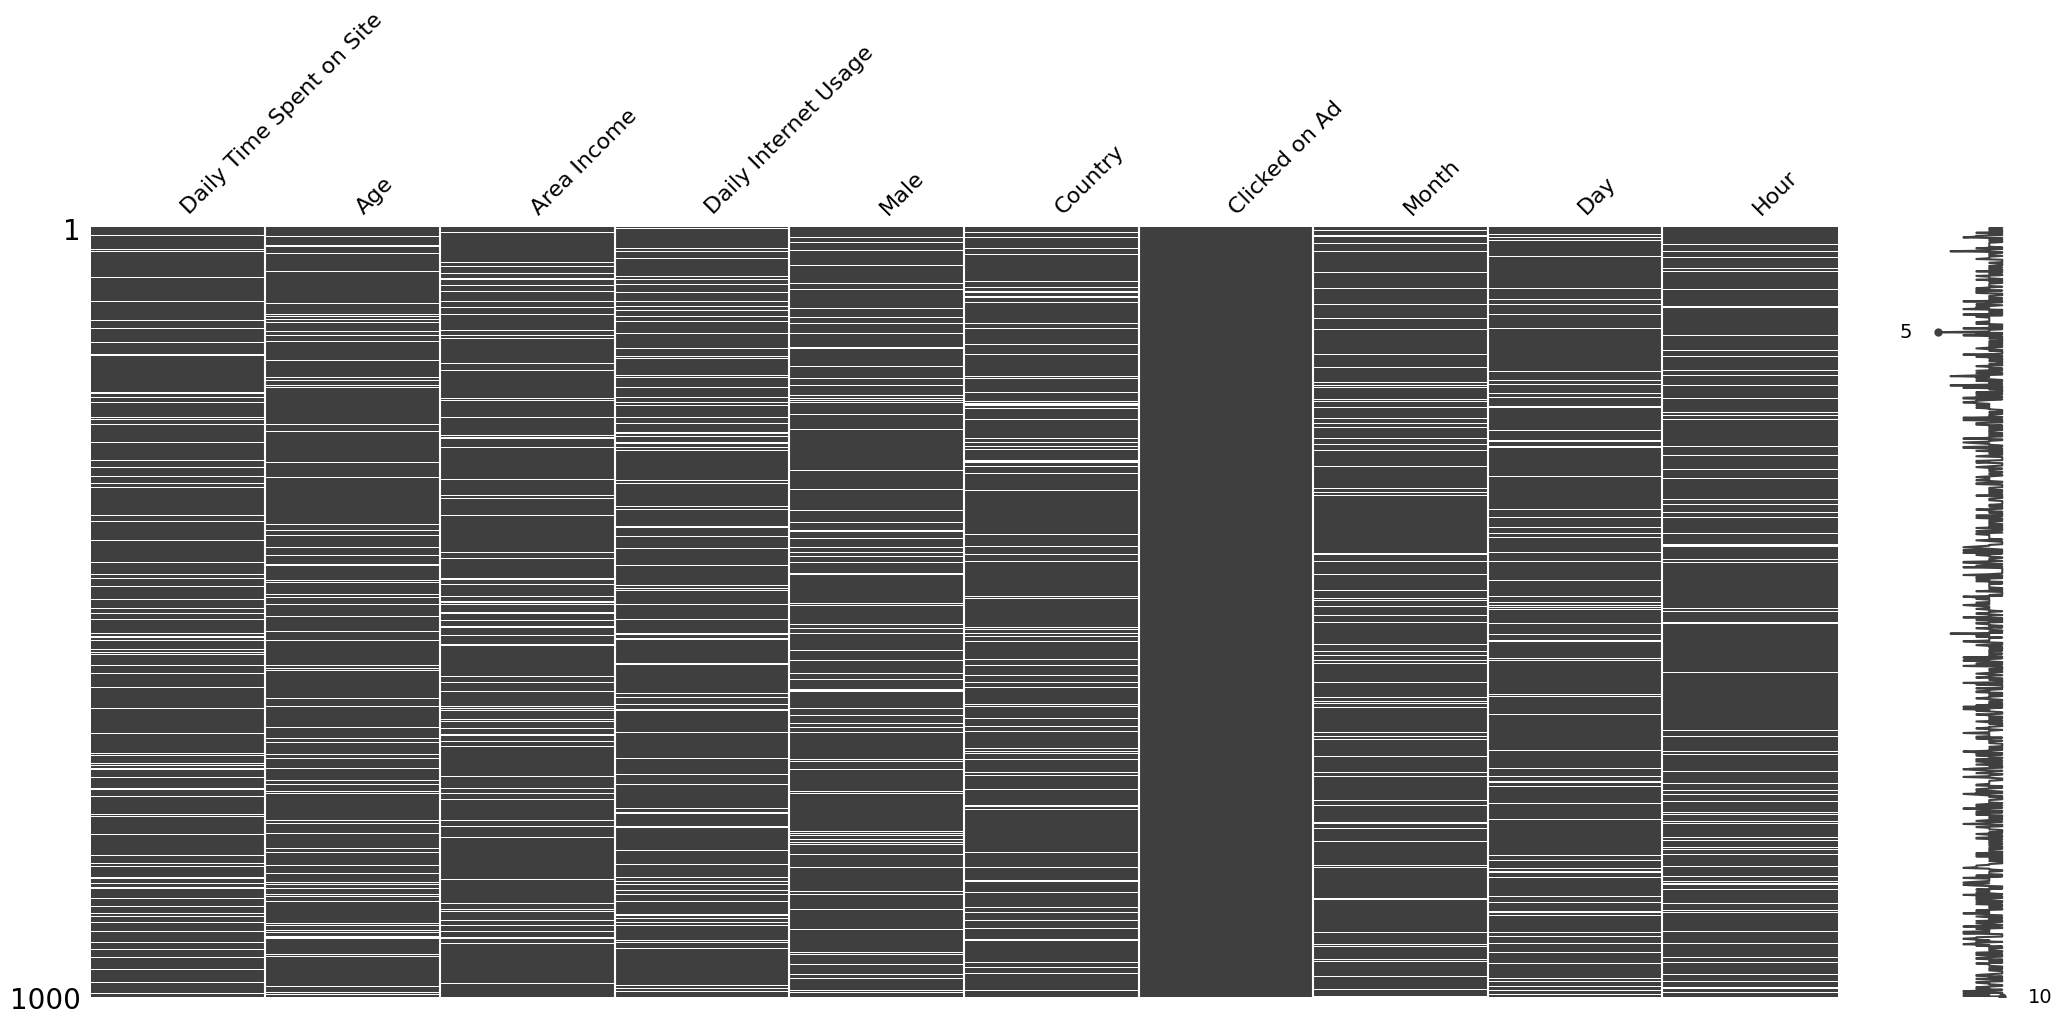

In [110]:
msno.matrix(df)

Now that our dataset contains some noise, we can happily move on with preprocessing.

## Preprocessing

The first thing to do in our preprocessing pipeline is, indeed, handling missing values. We will use a ``KNNImputer()`` with 5 neighbours for numerical features, as it can preserve the relationships between variables by considering the similarity between data points. For categorical and time-related features, we will use a `SimpleImputer()`.

Other than simple `StandardScaler()` and `OneHotEncoder()` for numerical and categorical features respectively, I decided to create a custom transformer to deal with the cyclic nature of time variables. 

`CyclicTransformer()` uses sine and cosine transformation to preserve this periodic property. It takes a `period` parameter which defines the cycle length, then converts each feature into two new components, sine and cosine values, according to the following relations:

- **sin_transformed** = $\sin \left( \frac{2 \pi x}{p} \right)$

- **cos_transformed** = $\cos \left( \frac{2 \pi x}{p} \right)$

for a feature *x* with a period *p*.


In [111]:
class CyclicTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period):
        self.period = period

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.concatenate([X_sin, X_cos], axis=1)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = [f"x{i}" for i in range(self.period)]  # Default feature names if none provided
        feature_names = []
        for feature in input_features:
            feature_names.append(f"{feature}_sin")  # Append '_sin' to feature names for sine components
            feature_names.append(f"{feature}_cos")  # Append '_cos' to feature names for cosine components
        return np.array(feature_names)

In [112]:
numerical_pipeline = Pipeline([
    ('knn_imp', KNNImputer(n_neighbors=5)),
    ('std_scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(drop='first',categories='auto', handle_unknown='ignore'))  # drop='first' avoids collinearity
])
    
cyclic_pipeline = lambda period: Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('custom', CyclicTransformer(period))
])

final_tf = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']),
        ('categorical', categorical_pipeline, ['Country']),
        ('male', SimpleImputer(strategy='most_frequent'), ['Male']),
        ('month', cyclic_pipeline(12), ['Month']),
        ('day', cyclic_pipeline(31), ['Day']),
        ('hour', cyclic_pipeline(24), ['Hour'])
    ],

    remainder='drop', 
    verbose_feature_names_out=False,
    sparse_threshold=0
)

In [113]:
final_tf

ColumnTransformer(sparse_threshold=0,
                  transformers=[('numerical',
                                 Pipeline(steps=[('knn_imp', KNNImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Daily Time Spent on Site', 'Age',
                                  'Area Income', 'Daily Internet Usage']),
                                ('categorical',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Co...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('custom',
                                                  CyclicTransformer(period=12))]),
                                 ['Month']),
                                ('day',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('custom',
                                                  CyclicTransformer(period=31))]),
                                 ['Day']),
                                ('hour',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('custom',
                                                  CyclicTransformer(period=24))]),
                                 ['Hour'])],
                  verbose_feature_names_out=False)

## Train and Test Splitting

We can now finally split the dataset into train and test, after separating the target from other features.

In [114]:
X = df.drop(['Clicked on Ad'], axis=1)
y = df['Clicked on Ad'] 

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

We will use 20% of the data for the test set and the remaining 80% will be devoted to training. Stratification ensures that class distribution is kept consistent across the training and testing sets.

## First Model Building

It's now time to build our first model pipeline, which includes data preprocessing through the application of the final transformer we defined before, dimensionality reduction and classification techniques.

I believe **Logistic Regression** is a reasonable choice to start out with, as it is simple and computationally efficient and it provides a baseline performance, against which we can test those of more complex models.

In [116]:
model_1 = Pipeline([
    ('trans', final_tf),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', LogisticRegression())
])

In [117]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 9)
(200, 9)
(800,)
(200,)


The data seems to be split correctly. Just as a further check to ensure that everything runs smoothly, I'll apply the `fit` and `predict` methods.

In [118]:
model_1.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('knn_imp',
                                                                   KNNImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Daily Time Spent on Site',
                                                   'Age', 'Area Income',
                                                   'Daily Internet Usage']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_...
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('custom',
                                                                   CyclicTransformer(period=31))]),
                                                  ['Day']),
                                                 ('hour',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('custom',
                                                                   CyclicTransformer(period=24))]),
                                                  ['Hour'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', LogisticRegression())])

In [119]:
model_1.predict(X_test)

array([1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

In [120]:
y_pred = model_1.predict(X_test)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

results = pd.DataFrame({'y_test': y_test, 'pred': y_pred})
results.reset_index(drop=True, inplace=True)

print(f'F1 score on the test set: {f1}')
print(f'Accuracy score on the test set: {accuracy}')

results

F1 score on the test set: 0.9696969696969697
Accuracy score on the test set: 0.97


,y_test,pred
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0
...,...,...
195,1.0,1.0
196,1.0,1.0
197,0.0,0.0
198,1.0,1.0


Here I took into account F1 and accuracy scores to evaluate our first model performance. Since our dataset is balanced, accuracy already provides a good measure of the overall performance. F1 still acts as a reliable measure in case of different costs between false positives and false negatives. 

The results seem to be very promising! However, we want to investigate other, possibly more complex, models as well, in order to find the best fit to our data.

## Search for Best Model

To look for the best model, we first have to test different combinations of classifiers, each with its specific hyperparameters, and dimensionality reduction strategies. Since we are dealing with a balanced set, we can bypass methods to handle imbalanced classes.

For dimensionality reduction techniques, I included **Principal Component Analysis**, **Linear Discriminant Analysis** and **Sequential Feature Selector**. 

As for classifiers, I ranged from simple linear or tree-based models and basic neural networks to more powerful ensamble learning methods.

In [121]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C': loguniform(0.001, 100),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [Perceptron()],
        'classifier__eta0': loguniform(0.001, 100),
        'classifier__max_iter': [1, 5, 10, 15, 50, 100],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 9]
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20, 30, 40],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [BaggingClassifier()],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__max_samples': [0.5, 0.8, 1.0],
        'classifier__max_features': [0.5, 0.8, 1.0]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.5],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    {
        'classifier': [AdaBoostClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.5]
    },
    {
        'classifier': [XGBClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.5],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }
]

In [122]:
all_configs = [
    dict(itertools.chain(*(e.items() for e in configuration))) 
    for configuration in itertools.product(dim_reduction_configs,classifier_configs)]

Here, we are generating all possible configurations, by means of Cartesian product between `dim_reduction_configs` and `classifier_configs`, through the `itertools.preduct` method. Then, we create a list of dictionaries, each of which represents a unique combination of dimensionality reduction technique, classifier, and their respective hyperparameters. 

In [123]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 36'

Just to check the result of this operation, we can print the first two configuratinos stored in `all_configs`.

In [124]:
all_configs[:2]

[{'dim_reduction': [None],
  'classifier': [LogisticRegression(solver='saga')],
  'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f26306412e0>,
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']},
 {'dim_reduction': [None],
  'classifier': [Perceptron()],
  'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f2630700340>,
  'classifier__max_iter': [1, 5, 10, 15, 50, 100],
  'classifier__class_weight': [None, 'balanced']}]

We first define the metrics to be used during model evaluation in `RandomizedSearchCV`. I included precision, recall and ROC AUC for completeness but, as I mentioned before, for this dataset accuracy and F1 scores are already quite exhaustive measures.

In [125]:
# Define additional evaluation metrics
scoring = {
    'f1': 'f1',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

We define a `RandomizedSearchCV` object which takes the list of all configurations and uses a 2-fold cross-validation exploiting the previously defined metrics.
For multiple scoring methods, the `refit` parameter is required for refitting the estimator according to the best found parameters after the search is complete.

In [126]:
# Perform RandomizedSearchCV
rs = RandomizedSearchCV(model_1,
                        param_distributions=all_configs,
                        n_iter=len(all_configs) * 5,
                        n_jobs=-1,
                        cv=2,
                        scoring=scoring,
                        refit='f1',
                        verbose=3
                       )

Then, we use the `cross_validate` function to return the best model for each fold iteration. It first splits the training data into cv folds (in this case, 5 folds), then training our `rs` model on **cv-1** folds of the data and evaluating the performance on the remaining one fold. 
For each fold iteration, the specified metrics are calculated and later aggregated.

In [127]:
scores = cross_validate(rs, X_train, y_train, scoring=scoring, cv=5, return_estimator=True, verbose=3)

              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=1.0, dim_reduction=LinearDiscriminantAnalysis(); accuracy: (test=0.912) f1: (test=0.911) precision: (test=0.929) recall: (test=0.894) roc_auc: (test=0.913) total time=   0.5s
[CV 1/2] END classifier=GradientBoostingClassifier(), classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=5

Since `return_estimator` is set to **True**, `cross_validate` also returns the estimators (models) fitted on each fold. This allows us to access the best model found during each fold iteration.

In [128]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'], estimator.best_estimator_.get_params()['classifier'].get_params())
    print('-'*100)

PCA(n_components=0.7)
BaggingClassifier(max_features=0.5, n_estimators=500) {'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
----------------------------------------------------------------------------------------------------
None
LogisticRegression(C=34.40211506159303, penalty='l1', solver='saga') {'C': 34.40211506159303, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
----------------------------------------------------------------------------------------------------
None
GradientBoostingClassifier(learning_rate=0.5, min_samples_leaf=2) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': Non

We now want to re-train the above 5 best models on the entire training set, in order to evaluate performances on the test set. 

From the obtained results, we create a dataframe which displays the classifier used by each model along with the related scores on the test set. 

The values are sorted by **F1 score**, prioritizing better result on the test set, so that the first entry will be our final best model, on which we will perform hyperparameter optimization.

In [129]:
results = pd.DataFrame(columns=['model', 'classifier_name', 'f1_train', 'f1_test', 'accuracy_train', 
                                'accuracy_test', 'precision_train', 'precision_test', 'recall_train', 
                                'recall_test', 'roc_auc_train', 'roc_auc_test'])

for index, estimator in enumerate(scores['estimator']):
    model_number = f'Model {index + 1}'
    classifier_name = estimator.best_estimator_.get_params()['classifier'].__class__.__name__

    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)

    f1_train = f1_score(y_train, pred_train)
    accuracy_train = accuracy_score(y_train, pred_train)
    precision_train = precision_score(y_train, pred_train)
    recall_train = recall_score(y_train, pred_train)
    roc_auc_train = roc_auc_score(y_train, pred_train)
    
    f1_test = f1_score(y_test, pred_test)
    accuracy_test = accuracy_score(y_test, pred_test)
    precision_test = precision_score(y_test, pred_test)
    recall_test = recall_score(y_test, pred_test)
    roc_auc_test = roc_auc_score(y_test, pred_test)

    results = pd.concat([results, pd.DataFrame([[model_number, classifier_name, f1_train, f1_test, accuracy_train, accuracy_test, 
                                                 precision_train, precision_test, recall_train, recall_test, roc_auc_train, roc_auc_test]], 
                                                 columns=results.columns)], ignore_index=True)
    results = results.sort_values(by=['f1_test', 'f1_train'], ascending=[False, False])

results

,model,classifier_name,f1_train,f1_test,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test
4,Model 5,BaggingClassifier,1.000000,0.974874,1.00000,0.975,1.000000,0.979798,1.0000,0.97,1.00000,0.975
0,Model 2,LogisticRegression,0.988708,0.970000,0.98875,0.970,0.992443,0.970000,0.9850,0.97,0.98875,0.970
1,Model 1,BaggingClassifier,1.000000,0.969697,1.00000,0.970,1.000000,0.979592,1.0000,0.96,1.00000,0.970
2,Model 3,GradientBoostingClassifier,1.000000,0.964824,1.00000,0.965,1.000000,0.969697,1.0000,0.96,1.00000,0.965
3,Model 4,AdaBoostClassifier,0.961735,0.949495,0.96250,0.950,0.981771,0.959184,0.9425,0.94,0.96250,0.950


## Hyperparameter Optimization

Now that we have finally selected our best candidate, we can tune hyperparameters adjusting the range to be closer to the selected model's.

Firstly, we define the pipeline for the best model.

In [130]:
best_model_pipeline = Pipeline([
    ('trans', final_tf),
    ('classifier', LogisticRegression(solver='saga', penalty='l1'))
])

In [131]:
best_params = {
    'classifier__C': loguniform(1.0, 2.5),  # Range around the best C value: C=1.5841793441714775
}

Again, `RandomizedSearchCV` identifies the best configuration for the model pipeline.

In [132]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = best_params,
    cv = RepeatedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1'
)

In [133]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('knn_imp',
                                                                                                KNNImputer()),
                                                                                               ('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['Daily '
                                                                                'Time '
                                                                                'Spent '
                                                                                'on '
                                                                                'Site',
                                                                                'Age',
                                                                                'Area '
                                                                                'Income',
                                                                                'Daily '
                                                                                'Internet '
                                                                                'Usage']),
                                                                              ('categorical',
                                                                               Pip...
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('custom',
                                                                                                CyclicTransformer(period=24))]),
                                                                               ['Hour'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(penalty='l1',
                                                                 solver='saga'))]),
                   n_iter=20,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f262cf7baf0>},
                   scoring='f1')

In [137]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('knn_imp',
                                                                   KNNImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Daily Time Spent on Site',
                                                   'Age', 'Area Income',
                                                   'Daily Internet Usage']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_...
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('custom',
                                                                   CyclicTransformer(period=31))]),
                                                  ['Day']),
                                                 ('hour',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('custom',
                                                                   CyclicTransformer(period=24))]),
                                                  ['Hour'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=1.8777974624471214, penalty='l1',
                                    solver='saga'))])

Finally, we calculate the scores of the refined model on the test set.

In [138]:
y_pred = rs_best.best_estimator_.predict(X_test)

# Calculate and print the evaluation metrics
f1_test = f1_score(y_test, y_pred)
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_pred)

print(f"F1 score on test set: {f1_test}")
print(f"Accuracy on test set: {accuracy_test}")
print(f"Precision on test set: {precision_test}")
print(f"Recall on test set: {recall_test}")
print(f"ROC AUC on test set: {roc_auc_test}")

F1 score on test set: 0.964824120603015
Accuracy on test set: 0.965
Precision on test set: 0.9696969696969697
Recall on test set: 0.96
ROC AUC on test set: 0.965


## Results Visualization

#### Confusion Matrix

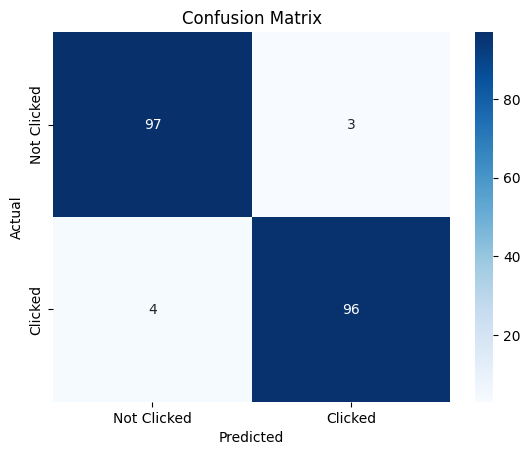

In [139]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Clicked', 'Clicked'], yticklabels=['Not Clicked', 'Clicked'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can see our model did a pretty good job with respect to both classes, correctly predicting 96 positives and 97 negatives, out of 200 items.

#### Precision-Recall trade-off

Text(0.5, 1.0, 'PR Curve: precisions/recalls tradeoff')

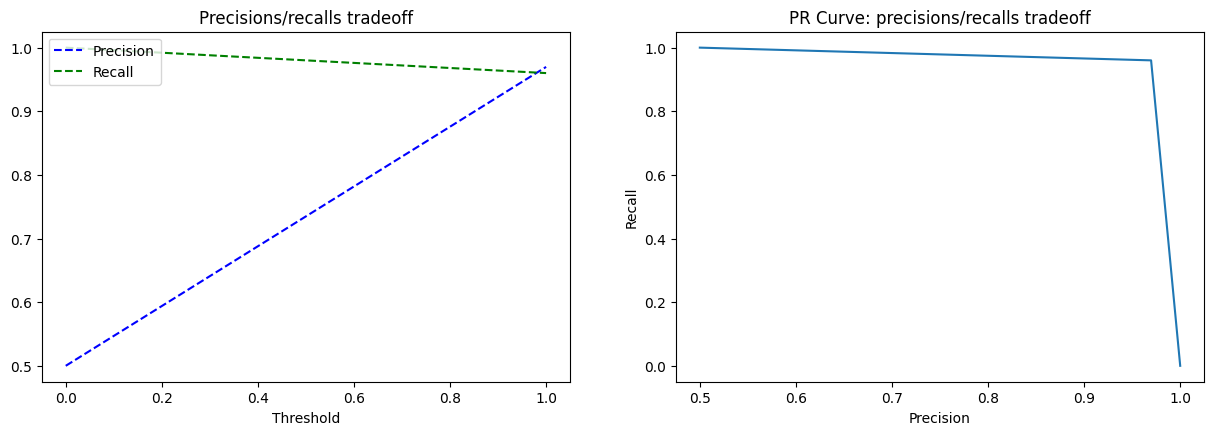

In [140]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.title("Precisions/recalls tradeoff")
    
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.subplot(2, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff")

**Precision and Recall vs. Threshold**

The first plot illustrates how precision and recall values change with different decision thresholds. As the it increases, we see that:
- precision increases too, as the model predicts fewer positive cases, but those it predicts are more likely to be true positives; 
- recall slowly decreases, because the model predicts fewer positive cases overall, missing more positive instances.


**Precision vs. Recall Curve**

The second plot directly shows the relationship between precision and recall across different thresholds:

- precision (x-axis) is plotted against Recall (y-axis);
- each point on the curve represents a different threshold setting.

The curve bending towards the upper-right corner indicates the model achieves high precision while maintaining high recall. 


#### ROC-AUC Curve

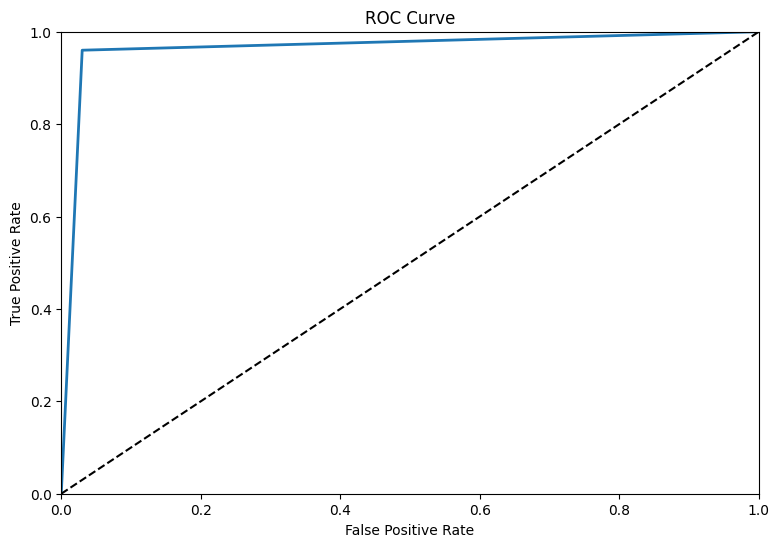

In [141]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(9,6)) 
plot_roc_curve(fpr, tpr)
plt.show()

The **ROC** curve illustrates the trade-off between TPR (True Positive Rate) and FPR (false Positive Rate) across different thresholds set by the model, while the diagonal dashed line from (0,0) to (1,1) represents the ROC curve of a purely random classifier.

The high Area Under the Curve (**AUC**) value indicates the model has very good discrimination ability between positive and negative classes, suggesting the quality of the performance across all possible thresholds.

#### Learning and Validation Curves

In [142]:
train_sizes, train_scores, test_scores = learning_curve(rs_best.best_estimator_,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

(0.8, 1.03)

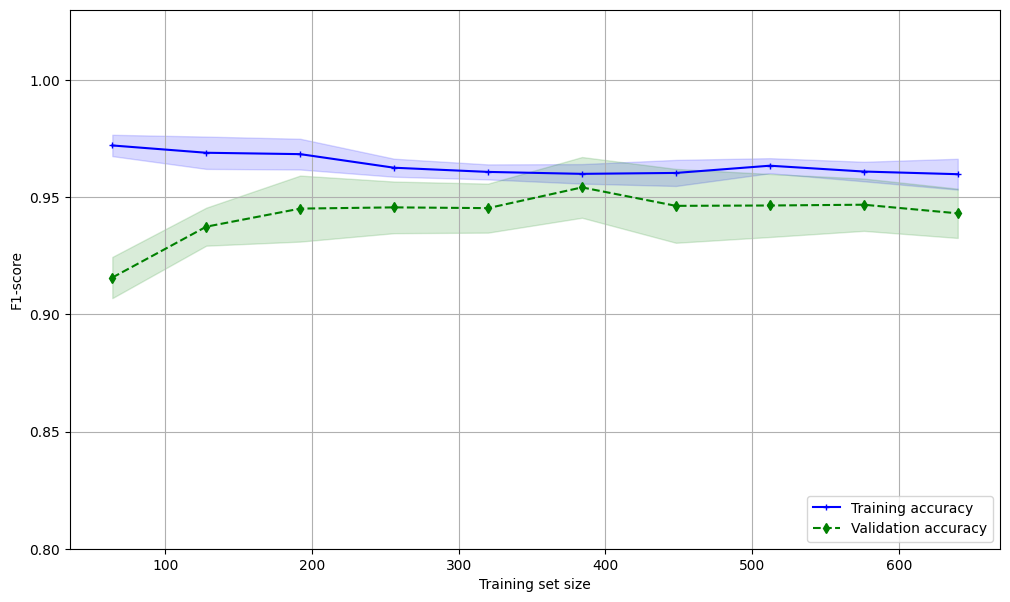

In [143]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.80, 1.03])

The learning curve for our model shows a typical pattern of initial overfitting due to the very small size of training data, followed by improved generalization. As we increase the size of the training set, the training score drops slightly below the validation score, as the model is encountering more varied data and starting to generalize better.

Following the increase in training set size, both the training and validation scores improve and converge, stabilizing at a high level with minimal distance between them. This demonstrates that our model is performing well with a good balance between bias and variance.

In [144]:
range_C = [0.05, 0.1, 0.4, 0.7, 1, 1.3, 1.6, 1.9, 2.2, 2.5, 10]
train_scores, test_scores = validation_curve(rs_best.best_estimator_,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.05, 10)

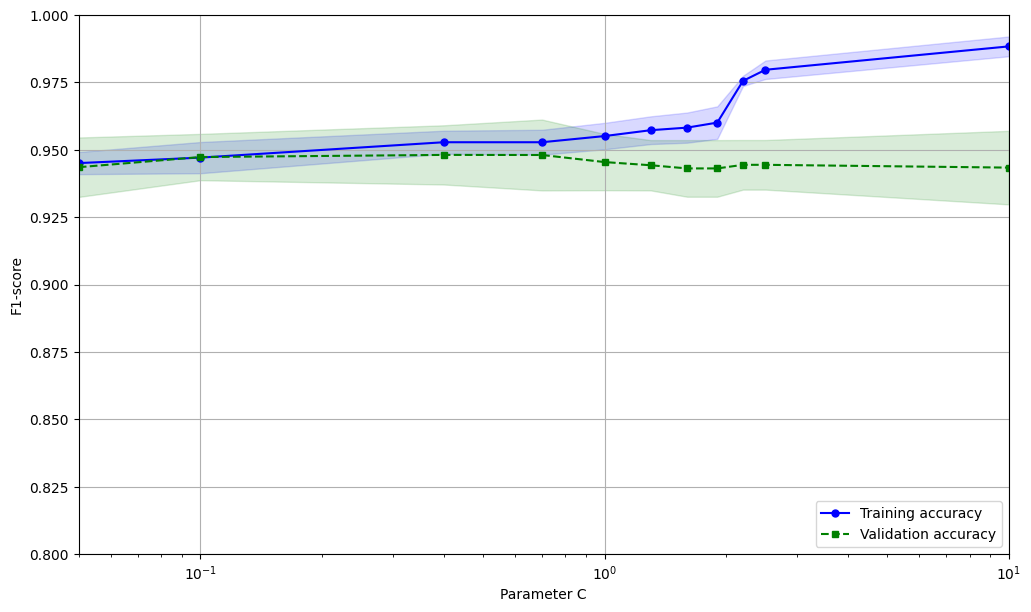

In [145]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.8, 1])
ax.set_xscale('log')
ax.set_xlim([0.05,10])

In this plot, the validation F1-score peaks around `C = 1` to `1.9` approximatively, suggesting that these values yield the best balance between bias and variance for the Logistic Regression model on this dataset. Choosing `C` within this range can optimize model performance, while exceeding it will likely result in overfitting.

## Conclusions

After thorough data exploration and preprocessing, we tested multiple models and found that logistic regression consistently outperformed others in terms of various evaluation metrics. Hyperparameter tuning slighlty improved its performance, validating its suitability for our task. Logistic regression provided valuable insights into feature importance, highlighting variables such as daily time spent on site and age as significant predictors of ad clicks.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eef4c561-2f7a-40b5-9a1c-124481b2cf33' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>